In [26]:
def storage_config(state, storage,dis_left,char_left, proxy_factor):
        #proxy_score = %eff of storage / fullness %
    
    proxy_score = pd.DataFrame({'Name':[],'Efficiency':[],'% Fullness':[],'Interconnector Capacity':[],\
                                'Storage Value':[]})

    state_to_fix = state

    stateus_maximus = [NSW, QLD, VIC ,TAS ,SA]

    for stateus in stateus_maximus:
        max_stor = 0
        if stateus.name_long == state_to_fix:

            cols = [stateus.name + ' fly', stateus.name + ' batt', stateus.name + ' phes',\
                    stateus.name + ' caes', stateus.name + ' hyd']
            
            for idx,stortus in enumerate(cols):
                stor_value = storage[stortus].iloc[-1]
                max_stor = getattr(stateus.stor, stortus[len(stateus.name)+1:])
                stor_perc = stor_value/max_stor
                stor_eff = getattr(stateus.eff, stortus[len(stateus.name)+1:])
                to_append = [stortus, stor_eff,stor_perc,'No',stor_value]
                to_series = pd.Series(to_append,index=proxy_score.columns)
                proxy_score = proxy_score.append(to_series,ignore_index=True)

            if dis_left > 0 :
                inter_possibility = inter_raw.loc[(inter_raw['From'] == state_to_fix)]
                state_to = inter_possibility['To'].unique()
            else:
                inter_possibility = inter_raw.loc[(inter_raw['To'] == state_to_fix)]
                state_to = inter_possibility['From'].unique()

            for stateus_again in stateus_maximus:
                
                if stateus_again.name_long in state_to:

                    cols = [stateus_again.name + ' fly', stateus_again.name + ' batt', stateus_again.name + ' phes',\
                    stateus_again.name + ' caes', stateus_again.name + ' hyd']
                                        
                    if dis_left > 0:
                        inter_cap = inter_possibility.loc[inter_possibility['To']==stateus_again.name_long,\
                                                          'Nominal Capacity'].sum()
                        
                    else:
                        inter_cap = inter_possibility.loc[inter_possibility['From']==stateus_again.name_long,\
                                                          'Nominal Capacity'].sum()
    
                            
                    for stortus in cols:
                        max_stor = storage[stortus].iloc[-1] + max_stor

                    for idx,stortus in enumerate(cols):
                        stor_value = storage[stortus].iloc[-1]
                        max_stor = getattr(stateus_again.stor, stortus[len(stateus_again.name)+1:])
                        stor_perc = stor_value/max_stor
                        stor_eff = getattr(stateus_again.eff, stortus[len(stateus_again.name)+1:])
                        to_append = [stortus, stor_eff,stor_perc,inter_cap,stor_value]
                        to_series = pd.Series(to_append,index=proxy_score.columns)
                        proxy_score = proxy_score.append(to_series,ignore_index=True)

    
    if dis_left > 0 :
        proxy_score['Proxy Score'] = np.where(proxy_score['Interconnector Capacity'] == 'No',\
                                              proxy_score['Efficiency']*proxy_score['% Fullness']*proxy_factor,\
                                              proxy_score['Efficiency']*proxy_score['% Fullness'])
    else:
        proxy_score['Proxy Score'] = np.where(proxy_score['Interconnector Capacity'] == 'No',\
                                              (proxy_score['Efficiency']/proxy_score['% Fullness'])*proxy_factor,\
                                              proxy_score['Efficiency']/proxy_score['% Fullness'])
        
    inter = proxy_score[proxy_score['Interconnector Capacity'] != 'No']
    inter_state = []

    for name in inter['Name'].unique():
        inter_state.append(name[:3])
    unique_inter_state = list(set(inter_state))

    for name in unique_inter_state:
        target_row = [row for row in inter['Name'] if name in row]
        to_remove_inter = inter[inter['Name'].isin(target_row)]
        max_proxy_score = to_remove_inter['Proxy Score'].max()
        to_remove_inter = to_remove_inter[to_remove_inter['Proxy Score'] != max_proxy_score]
        
        to_remove_inter_lst = list(to_remove_inter['Name'])

        proxy_score=proxy_score[~proxy_score['Name'].isin(to_remove_inter_lst)]
    
    
    return(proxy_score.sort_values(['Proxy Score'],ascending=False))

In [67]:
def char_dischar(state, storage, dis_left, char_left,proxy_factor):

    loss = 0
    leftover = 0
    end_stor = 0
    #print(state)
    state_to_fix = state
    
    if dis_left > 0:
        char_or_dis = 'Discharge'
    else:
        char_or_dis = 'Charge'

    #configuration_raw = configuration_raw.loc[(configuration_raw['State']==state_to_fix) &\
                                              #(configuration_raw['Type']==char_or_dis)]

    #configuration = calc_proxy(configuration_raw,storage,proxy_factor,char_or_dis)
    
    configuration  = storage_config(state, storage,dis_left,char_left, proxy_factor)
    #print(configuration)
    #configuration = configuration 
    
    configuration['New Storage Value']=0
    
    while dis_left + char_left > 0:
        interconnection = 0
        for index,state_to in configuration.iterrows():
            #Collecting State Name
            state_to_send = state_to['Name'][0:3]
            if state_to_send[-1] == " ":
                state_to_send = state_to_send[:-1]
                
            state_to_send_class = getattr(sys.modules[__name__], state_to_send)

            #Collecting storage type
            storage_type = state_to['Name'][len(state_to_send_class.name)+1:]
            storage_eff = getattr(state_to_send_class.eff, storage_type)
            storage_pwr = getattr(state_to_send_class.pwr, storage_type)
            storage_stor = getattr(state_to_send_class.stor, storage_type)
            
            #print("State: %s, Type: %s, Storage: %f, Efficiency: %f" %(state_to_send, storage_type,  storage_stor, storage_eff))
            storage_value = state_to['Storage Value']

            if state_to['Interconnector Capacity'] == 'No':
                stor_cap = storage_pwr
            else:
                inter_cap = state_to['Interconnector Capacity']
                if inter_cap < storage_pwr:
                    stor_cap = inter_cap
                else: 
                    stor_cap = storage_pwr
                    
                # will not be perfect calculation but good for checking interconneciton working properly
                interconnection = interconnection + stor_cap 

            if char_left > 0:
                if storage_value < storage_stor:
                    charg = charge(char_left, storage_value, storage_eff,\
                                      storage_stor,\
                                      stor_cap)
                    storage_final = charg[0]
                    configuration.loc[index,'New Storage Value'] = storage_final
                    char_left = charg[1]
                    loss = charg[2]
                    error = charg[3]
                    
            else:
                if storage_value > 0:
                    discharg = discharge(dis_left, storage_value, storage_eff,\
                                      stor_cap)
                    storage_final = discharg[0]
                    configuration.loc[index,'New Storage Value'] = storage_final
                    dis_left = discharg[1]
                    loss = discharg[2]
                    error = discharg[3]
                    
            leftover = dis_left + char_left
           
            if leftover < 0:
                break
            
        if leftover > 0:
            end_stor = 1
            break
        else:
            leftover = 0

    configuration['New Storage Value'] = np.where(configuration['New Storage Value']==0, \
                                                      configuration['Storage Value'],\
                                                      configuration['New Storage Value'])
    
    #print(interconnection)
    #print(configuration)
    return(configuration,leftover,interconnection,error)

In [2]:
def decide_state_r(state):
    
    if state == 'New South Wales':
        index = 0
    elif state == 'Queensland':
        index = 1
    elif state == 'Victoria':
        index = 2
    elif state == 'Tasmania':
        index = 3
    elif state == 'South Australia':
        index = 4
    return(index)

In [3]:
def decide_state(index):
    if index == 0:
        #Run NSW's Interconnector
        p = 'New South Wales'
    elif index == 1:
        #Run QLD's Interconnector
        p = 'Queensland'
    elif index == 2:
        #Run VIC's Interconnector
        p = 'Victoria'
    elif index == 3:
        #Run VIC's Interconnector
        p = 'Tasmania'
    elif index == 4:
        #Run VIC's Interconnector
        p = 'South Australia'
    return(p)

In [54]:
def discharge(discharge_amt, stor_amt, stor_eff, stor_cap):
    
    loss = 0
    
    #print('Discharge Amount: %d, Storage Amount: %d, Storage Eff: %f, Storage Pwr Capacity: %d' %(discharge_amt,stor_amt, stor_eff , stor_cap))
    
    pwr_cap = stor_cap *time_idx
    error = ''
    
    if pwr_cap < discharge_amt: # CASE 1: If Power capacity DOES NOT meet discharge requirements--------------------
        total_discharged = pwr_cap
        
        if stor_amt < total_discharged: # CASE 1A: If Storage level DOES NOT meet discharge requirements------------
            total_discharged = stor_amt
            new_stor_amt = 0
            discharge_leftover = discharge_amt- (total_discharged * (stor_eff))
            error = 'Power and Storage Capacity DOES NOT meet discharge requirements'
        
        else: #CASE 1B: If Storage level DOES meet discharge requirements-------------------------------------------
            new_stor_amt = stor_amt - total_discharged
            discharge_leftover = discharge_amt - (total_discharged * (stor_eff))
            error = 'Only Power Capacity DOES NOT meets discharge requirements'
                                                 
    else: #CASE 2: If Power Capacity DOES meet discharge requirements-----------------------------------------------
        total_discharged = discharge_amt
        
        if stor_amt < total_discharged: #CASE 2A: If Storage Level DOES NOT meet discharge requirements--------------
            total_discharged = stor_amt
            new_stor_amt = 0
            discharge_leftover = discharge_amt- (total_discharged * (stor_eff))
            error = 'Only Storage Capacity DOES NOT meets discahrge requirements'
            
        else: #CASE 2B: If Storage Level DOES meet discharge requirements-------------------------------------------
            discharge_leftover = 0
            new_stor_amt = stor_amt - discharge_amt
   
    return([new_stor_amt, discharge_leftover,loss,error])

In [71]:
def charge(charge_amt, stor_amt , stor_eff, chargemax, stor_cap):
    
    loss = 0
    
   #print('Charge Amount: %d, Storage Amount: %d, Storage Eff: %f, Storage Max: %d, Storage Pwr Capacity: %d' %(charge_amt, stor_amt , stor_eff, chargemax, stor_cap))
    pwr_cap = stor_cap * time_idx
    error=""
    
    if pwr_cap < charge_amt: # CASE 1: If Power capacity DOES NOT meet charge requirements--------------------
        total_charged = pwr_cap
        
        if stor_amt + total_charged >= chargemax: # CASE 1A: If Storage level DOES NOT meet charge requirements------------
            total_charged = chargemax - stor_amt
            new_stor_amt = chargemax
            charge_leftover = charge_amt - (total_charged * (1+(1-stor_eff)))
            error = 'Power and Storage Capacity DOES NOT meet charge requirements'
        
        else: #CASE 1B: If Storage level DOES meet charge requirements-------------------------------------------
            new_stor_amt = stor_amt + total_charged
            charge_leftover = charge_amt - (total_charged * (1+(1-stor_eff)))
            error = 'Only Power Capacity DOES NOT meets charge requirements'
                                                 
    else: #CASE 2: If Power Capacity DOES meet charge requirements-----------------------------------------------
        total_charged = charge_amt
        
        if stor_amt + total_charged >= chargemax: #CASE 2A: If Storage Level DOES NOT meet charge requirements--------------
            total_charged = chargemax - stor_amt
            new_stor_amt = chargemax
            charge_leftover = charge_amt - (total_charged * (1+(1-stor_eff)))
            error = 'Only Storage Capacity DOES NOT meets charge requirements'
            
        else: #CASE 2B: If Storage Level DOES meet charge requirements-------------------------------------------
            charge_leftover = 0
            new_stor_amt = stor_amt + charge_amt

    return([new_stor_amt, charge_leftover, loss,error])

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sys
#sns.set()

# Loading All Data

In [7]:
xls = pd.ExcelFile('Raw_Data.xlsx')
inter_raw = pd.read_excel(xls, 'Interconnector Raw')
Demand = pd.read_excel(xls, 'Scheduled Demand')
NSW_TGen = pd.read_excel(xls, 'NSW Fuels')
QLD_TGen = pd.read_excel(xls, 'QLD Fuels')
VIC_TGen = pd.read_excel(xls, 'VIC Fuels')
TAS_TGen = pd.read_excel(xls, 'Tas Fuels')
SA_TGen = pd.read_excel(xls, 'SA Fuels')

# Interconnector Settings

In [8]:
inter_raw['Nominal Capacity'] = inter_raw['Nominal Capacity'].str.replace('MW','')
inter_raw['Nominal Capacity'] = pd.to_numeric(inter_raw['Nominal Capacity'] )

# Defining Constants

## Universal Constants

In [9]:
re_factor=1
power_factor=1
storage_factor=1

proxy_factor = 1.5
fly_eff = 0.9
batt_eff = 0.9
phes_eff = 0.8
caes_eff = 0.5
hyd_eff = 0.35

## New South Wales

In [10]:
class NSW:
    
    class eff:
        fly = fly_eff
        batt = batt_eff
        phes = phes_eff
        caes = caes_eff
        hyd = hyd_eff
        pass
    class pwr:
        fly = 4000*power_factor #MW
        batt = 6000*power_factor #MW
        phes = 17000*power_factor #MW
        caes = 17000*power_factor #MW
        hyd = 50000*power_factor #MW
        pass
    class stor:
        fly = 500*1000*storage_factor #MWh
        batt = 3200*1000*storage_factor  #MWh
        phes = 8000*1000*storage_factor  #MWh
        caes = 8000*1000*storage_factor  #MWh
        hyd = 2000*1000*storage_factor  #MWh
        pass   

    init_stor_factor = 1

    re_multiplier = 9.3*re_factor
    
    name = 'NSW'
    
    name_long = 'New South Wales'
    
    pass

## Queensland

In [11]:
class QLD:
    class eff:
        fly = fly_eff
        batt = batt_eff
        phes = phes_eff
        caes = caes_eff
        hyd = hyd_eff
        pass
    class pwr:
        fly = 6000*power_factor #MW
        batt = 6000*power_factor #MW
        phes = 17000*power_factor #MW
        caes = 17000*power_factor #MW
        hyd = 50000*power_factor #MW
        pass
    class stor:
        fly = 500*1000*storage_factor  #MWh
        batt = 3200*1000*storage_factor  #MWh
        phes = 6000*1000*storage_factor  #MWh
        caes = 6000*1000*storage_factor  #MWh
        hyd = 10000*1000*storage_factor  #MWh
        pass   

    init_stor_factor = 0.6

    re_multiplier = 8.6*re_factor
    
    name = 'QLD'
    
    name_long = 'Queensland'
    
    pass

## Victoria

In [12]:
class VIC:
    class eff:
        fly = fly_eff
        batt = batt_eff
        phes = phes_eff
        caes = caes_eff
        hyd = hyd_eff
        pass
    class pwr:
        fly = 2000*power_factor #MW
        batt = 10000*power_factor #MW
        phes = 20000*power_factor #MW
        caes = 20000*power_factor #MW
        hyd = 20000*power_factor #MW
        pass
    class stor:
        fly = 2000*1000*storage_factor  #MWh
        batt = 3000*1000*storage_factor  #MWh
        phes = 9000*1000*storage_factor  #MWh
        caes = 9000*1000*storage_factor  #MWh
        hyd = 10000*1000*storage_factor  #MWh
        pass   

    init_stor_factor = 0.65

    re_multiplier = 4.2*re_factor
    
    name = 'VIC'
    
    name_long = 'Victoria'
    
    pass

## Tasmania

In [13]:
class TAS:
    class eff:
        fly = fly_eff
        batt = batt_eff
        phes = phes_eff
        caes = caes_eff
        hyd = hyd_eff
        pass
    class pwr:
        fly =1000*power_factor #MW
        batt = 5000*power_factor #MW
        phes = 15000*power_factor #MW
        caes = 15000*power_factor #MW
        hyd = 15000*power_factor #MW
        pass
    class stor:
        fly = 1000*1000*storage_factor  #MWh
        batt = 1500*1000*storage_factor  #MWh
        phes = 5000*1000*storage_factor  #MWh
        caes = 5000*1000*storage_factor  #MWh
        hyd = 5000*1000*storage_factor  #MWh
        pass

    init_stor_factor = 0.65

    re_multiplier = 7.3*re_factor
    
    name = 'TAS'
    name_long = 'Tasmania'
    
    pass

## South Australia

In [14]:
class SA:
    class eff:
        fly = fly_eff
        batt = batt_eff
        phes = phes_eff
        caes = caes_eff
        hyd = hyd_eff
        pass
    class pwr:
        fly = 200*power_factor  #MW
        batt = 1000*power_factor #MW
        phes = 2000*power_factor #MW
        caes = 2000*power_factor #MW
        hyd = 2000*power_factor #MW
        pass
    class stor:
        fly = 300*1000*storage_factor  #MWh
        batt = 400*1000*storage_factor  #MWh
        phes = 1200*1000*storage_factor  #MWh
        caes = 1000*1000*storage_factor  #MWh
        hyd = 1000*1000*storage_factor  #MWh
        pass   

    init_stor_factor = 0.55

    re_multiplier = 1.8*re_factor
    
    name = 'SA'
    
    name_long = 'South Australia'
    
    pass

# Energy Demand/Generation/Storage Info Data Pre-processing

In [15]:
NSW_R_Gen = NSW_TGen[['Time-ending','Rooftop PV','Solar','Wind']]
QLD_R_Gen = QLD_TGen[['Time-ending','Rooftop PV','Solar','Wind']]
VIC_R_Gen = VIC_TGen[['Time-ending','Rooftop PV','Solar','Wind']]
TAS_R_Gen = TAS_TGen[['Time-ending','Rooftop PV','Solar','Wind']]
SA_R_Gen = SA_TGen[['Time-ending','Rooftop PV','Solar','Wind']]

NSW_Demand = Demand[['NSW1 Scheduled Demand']]
QLD_Demand = Demand[['QLD1 Scheduled Demand']]
VIC_Demand = Demand[['VIC1 Scheduled Demand']]
TAS_Demand = Demand[['TAS1 Scheduled Demand']]
SA_Demand = Demand[['SA1 Scheduled Demand']]

In [16]:
state_to_fix = [NSW, QLD, VIC ,TAS ,SA]
stor_info = pd.DataFrame({'No.':['Efficiency (%)', 'Power Capacity (MW)', 'Storage Capacity (MWh)', 'Renewable Factor']})

for states_app in state_to_fix:
    
    parameters = [states_app.eff, states_app.pwr, states_app.stor, states_app.re_multiplier]
    cols = [states_app.name + ' Flywheels', states_app.name + ' Batt', states_app.name + ' PHES',\
                states_app.name + ' CAES', states_app.name + ' Hydrogen', states_app.name + ' Renewable Factor']
    state_storage = pd.DataFrame()
    
    for parameter in parameters:
        
        if parameter == states_app.re_multiplier:
            to_append = [0, 0, 0, 0, 0, states_app.re_multiplier]
        else:
            to_append = [parameter.fly, parameter.batt, parameter.phes, parameter.caes, parameter.hyd,0]
        
                
        if parameter == states_app.stor:
            maxstor = sum(to_append)  
            
        a_series = pd.Series(to_append, index=cols)
        state_storage = state_storage.append(a_series, ignore_index=True, sort=False)
        state_storage = state_storage.reindex(cols, axis=1)
    
    stor_info = pd.concat([stor_info, state_storage], axis=1)
    
stor_info.set_index('No.', inplace = True)

In [17]:
NSW_info1 = pd.concat([NSW_R_Gen,NSW_Demand],axis = 1)
NSW_info1.rename(columns={'NSW1 Scheduled Demand': 'Demand'},inplace = True)
NSW_info1['re_multi'] = NSW.re_multiplier

QLD_info1 = pd.concat([QLD_R_Gen,QLD_Demand],axis = 1)
QLD_info1.rename(columns={'QLD1 Scheduled Demand': 'Demand'},inplace = True)
QLD_info1['re_multi'] = QLD.re_multiplier

TAS_info1 = pd.concat([TAS_R_Gen,TAS_Demand],axis = 1)
TAS_info1.rename(columns={'TAS1 Scheduled Demand': 'Demand'},inplace = True)
TAS_info1['re_multi'] = TAS.re_multiplier

SA_info1 = pd.concat([SA_R_Gen,SA_Demand],axis = 1)
SA_info1.rename(columns={'SA1 Scheduled Demand': 'Demand'},inplace = True)
SA_info1['re_multi'] = SA.re_multiplier

VIC_info1 = pd.concat([VIC_R_Gen,VIC_Demand],axis = 1)
VIC_info1.rename(columns={'VIC1 Scheduled Demand': 'Demand'},inplace = True)
VIC_info1['re_multi'] = VIC.re_multiplier

# Define if averaging or running full 

In [18]:
input_type = ''

X = [NSW_info1, QLD_info1, VIC_info1, TAS_info1, SA_info1]
Y = pd.DataFrame()
for item in X:
    if str(item) == str(NSW_info1):
        name = 'NSW'
    elif str(item) == str(QLD_info1):
        name = 'QLD'
    elif str(item) == str(VIC_info1):
        name = 'VIC'
    elif str(item) == str(TAS_info1):
        name = 'TAS'
    elif str(item) == str(SA_info1):
        name = 'SA'
        
    for states_col in item.columns:
        if states_col == 'Time-ending':
            continue
        process_array = item[states_col]
        
        if input_type == 'half':
            x = ((process_array + process_array.shift(-1)))[::2]
            time_idx = 1
        else: 
            x = process_array
            time_idx = 0.5
        Y[name +' ' + states_col] = x

# Defining Charge, Discharge Required and Total Renewable Generation

In [19]:
X = [NSW, QLD, VIC, TAS, SA]

states = pd.DataFrame()
renewable_generation = pd.DataFrame()

for item in X:
    state_name = item.name
    total_renewable = (Y[state_name + ' Rooftop PV'] + Y[state_name +' Solar'] +\
                       Y[state_name +' Wind'])*Y[state_name +' re_multi']
    states[state_name+ ' To_Re']= total_renewable
    Y[state_name+ ' To_Re'] = total_renewable
    states[state_name+' Charge(MWh)'] = np.where(Y[state_name+' Demand']<Y[state_name+' To_Re'], \
                                                 Y[state_name+' To_Re']-Y[state_name+' Demand'],0)
    states[state_name+' Discharge(MWh)'] = np.where(Y[state_name+' Demand']<Y[state_name+' To_Re'],\
                                                    0, Y[state_name+' Demand']-Y[state_name+' To_Re'])
    renewable_generation[state_name + ' Solar'] = Y[state_name +' Solar']
    renewable_generation[state_name + ' Wind'] = Y[state_name +' Wind']
    
states['DateTime'] = NSW_info1['Time-ending']
states = states.set_index(['DateTime'])

# Defining Simulation Data

In [20]:
#states = pd.concat([NSW_x,QLD_x,VIC_x,TAS_x,SA_x], axis = 1)
makezeros = [0]*len(states.columns)
b_series = pd.DataFrame(makezeros, index = states.columns)
states = pd.concat([b_series.T,states]).reset_index(drop=True)

In [21]:
all_storage_raw= pd.DataFrame({'NSW fly' : [] , 'NSW batt':[], \
                               'NSW phes' : [], 'NSW caes' : [],\
                               'NSW hyd' : [], 'NSW Interconnector/s' : [],\
                                'QLD fly' : [] , 'QLD batt':[], \
                               'QLD phes' : [], 'QLD caes' : [],\
                               'QLD hyd' : [], 'QLD Interconnector/s' : [],\
                                'VIC fly' : [] , 'VIC batt':[], \
                               'VIC phes' : [], 'VIC caes' : [],\
                               'VIC hyd' : [], 'VIC Interconnector/s' : [],\
                                 'TAS fly' : [] , 'TAS batt':[], \
                               'TAS phes' : [], 'TAS caes' : [],\
                               'TAS hyd' : [], 'TAS Interconnector/s' : [],\
                                 'SA fly' : [] , 'SA batt':[], \
                               'SA phes' : [], 'SA caes' : [],\
                               'SA hyd' : [], 'SA Interconnector/s' : []})

In [22]:
interconnection_raw = pd.DataFrame({'NSW Leftover':[], 'QLD Leftover':[], 'VIC Leftover':[],'TAS Leftover':[],\
                                'SA Leftover':[]})

In [23]:
storage_inter = all_storage_raw.copy()
initial_factor = []

for columns in storage_inter:
    storage_type = columns[4:]
    state_to_send = columns[0:3]
    
    if state_to_send[2:3] == " ":
        state_to_send = columns[0:2]
        storage_type = columns[3:]
        
    if storage_type == 'Interconnector/s':
        stor_init_amt = 0
        
    else:
        state_to_send_class = getattr(sys.modules[__name__], state_to_send)
        stor_stor = getattr(state_to_send_class.stor, storage_type)
        init_factor = state_to_send_class.init_stor_factor
        stor_init_amt = stor_stor*init_factor
    
    initial_factor.append(stor_init_amt)
a_series = pd.Series(initial_factor,index=storage_inter.columns)
storage_inter = storage_inter.append(a_series,ignore_index=True)

In [24]:
pd.set_option("display.max_columns", None)
storage_inter

,NSW fly,NSW batt,NSW phes,NSW caes,NSW hyd,NSW Interconnector/s,QLD fly,QLD batt,QLD phes,QLD caes,QLD hyd,QLD Interconnector/s,VIC fly,VIC batt,VIC phes,VIC caes,VIC hyd,VIC Interconnector/s,TAS fly,TAS batt,TAS phes,TAS caes,TAS hyd,TAS Interconnector/s,SA fly,SA batt,SA phes,SA caes,SA hyd,SA Interconnector/s
0,500000.0,3200000.0,8000000.0,8000000.0,2000000.0,0.0,300000.0,1920000.0,3600000.0,3600000.0,6000000.0,0.0,1300000.0,1950000.0,5850000.0,5850000.0,6500000.0,0.0,650000.0,975000.0,3250000.0,3250000.0,3250000.0,0.0,165000.0,220000.0,660000.0,550000.0,550000.0,0.0


# Running Main Code

In [72]:
interconnection = interconnection_raw.copy()
states2 = states.head(26)
total_len = len(states2)-1
end = 0
storage = storage_inter.copy()

hold = [NSW,QLD,VIC,TAS,SA] # 1 = NSW, 2 = QLD, 3 = VIC, 4 = TAS, 5 = SA

for index, row in states2.iterrows():
    temp_storage = pd.DataFrame(storage.iloc[-1]).T 
    print("I'm still going. Be Patient. I'm at %d/%d"%(index,total_len))
    if index == 0:
        continue
    
    for index_state ,item in enumerate(hold):
        #print(item.name) 
        target_state = [col for col in states2.columns if item.name in col]
        char_left = row[target_state[1]]
        dis_left = row[target_state[2]]
        reference_idx = char_dischar(item.name_long,temp_storage,dis_left,char_left, proxy_factor)
        configuration = reference_idx[0]
        leftover = reference_idx[1]
        interconnection_cap = reference_idx[2]
        error_term = reference_idx[3]
                
        for idx, config in configuration.iterrows():
            reference = config['Name']
            temp_storage[reference] = config['New Storage Value']
        #print(reference_idx)
        #print('Leftover: %d' %(leftover))
        if leftover>0:
            
            if char_left > 0:
                #print(leftover)
                thingo = item.name+' Interconnector/s'
                temp_storage[thingo] = leftover
            elif dis_left>0:
                print('The Simulation Failed at %s due to %s'%(item.name_long, error_term))
                end = 1
                break
            
    if end == 1:
        break

    storage = storage.append(temp_storage).reset_index(drop=True)      
    

I'm still going. Be Patient. I'm at 0/25
I'm still going. Be Patient. I'm at 1/25
I'm still going. Be Patient. I'm at 2/25
I'm still going. Be Patient. I'm at 3/25
I'm still going. Be Patient. I'm at 4/25
I'm still going. Be Patient. I'm at 5/25
I'm still going. Be Patient. I'm at 6/25
I'm still going. Be Patient. I'm at 7/25
I'm still going. Be Patient. I'm at 8/25
I'm still going. Be Patient. I'm at 9/25
I'm still going. Be Patient. I'm at 10/25
I'm still going. Be Patient. I'm at 11/25
I'm still going. Be Patient. I'm at 12/25
I'm still going. Be Patient. I'm at 13/25
I'm still going. Be Patient. I'm at 14/25
I'm still going. Be Patient. I'm at 15/25
I'm still going. Be Patient. I'm at 16/25
I'm still going. Be Patient. I'm at 17/25
I'm still going. Be Patient. I'm at 18/25
I'm still going. Be Patient. I'm at 19/25
I'm still going. Be Patient. I'm at 20/25
I'm still going. Be Patient. I'm at 21/25
I'm still going. Be Patient. I'm at 22/25
I'm still going. Be Patient. I'm at 23/25
I'

# Exporting Data 

In [ ]:
#storage.to_json('tester - Result.json',orient='columns')
stor_info.to_json('tester - Inputs.json',orient='columns')

# Plotting 

simulation_type = 'Run 1'
result_filename = simulation_type + ' - Results.json'
input_filename = simulation_type + ' - Inputs.json'
inputs = pd.read_json (input_filename)
inputs =inputs.T
print(result_filename)
results = pd.read_json (result_filename)

## Interconnection

x = interconnection.index
y= interconnection.columns
y_nsw = interconnection[y[0]]
y_qld = interconnection[y[1]]
y_vic = interconnection[y[2]]
y_tas = interconnection[y[3]]
y_sa = interconnection[y[4]]
y = y[::-1]

fig, axs = plt.subplots(5, 1, sharex = True, figsize = (15,20))

axs[0].plot(x, y_nsw)
axs[0].set_title('NSW Interconnector')

axs[1].plot(x, y_qld, 'tab:orange')
axs[1].set_title('QLD Interconnector')

axs[2].plot(x, y_vic, 'tab:green')
axs[2].set_title('VIC Interconnector')

axs[3].plot(x, y_tas, 'tab:red')
axs[3].set_title('TAS Interconnector')

axs[4].plot(x, y_sa, 'tab:cyan')
axs[4].set_title('SA Interconnector')

for ax in axs.flat:
    ax.set(ylabel='Energy Transmitted (MWh)')



## New South Wales

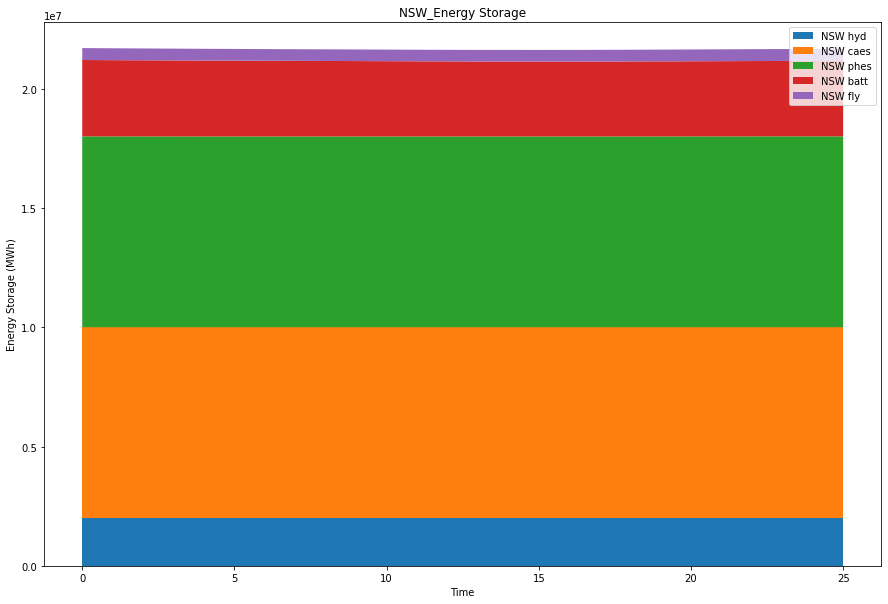

In [70]:
nsw_storage = storage.iloc[:,0:5]
x = nsw_storage.index #NSW['Time-ending']
y= nsw_storage.columns
y_fly = nsw_storage[y[0]]
y_batt = nsw_storage[y[1]]
y_phes = nsw_storage[y[2]]
y_caes = nsw_storage[y[3]]
y_hyd = nsw_storage[y[4]]
y = y[::-1]

plt.figure(figsize=(15,10))
plt.stackplot(x, y_hyd, y_caes, y_phes, y_batt ,y_fly, labels=y)
plt.title('NSW_Energy Storage')
plt.ylabel ('Energy Storage (MWh)'),  plt.xlabel('Time')
plt.legend(loc='upper right')


In [ ]:
fig, axs = plt.subplots(5, 1, sharex = True, figsize = (15,20))

axs[0].plot(x, y_fly)
axs[0].set_title('NSW FlyWheels')

axs[1].plot(x, y_batt, 'tab:orange')
axs[1].set_title('NSW Batteries')

axs[2].plot(x, y_phes, 'tab:green')
axs[2].set_title('NSW Pumped Hydro')

axs[3].plot(x, y_caes, 'tab:red')
axs[3].set_title('NSW Compressed Air')

axs[4].plot(x, y_hyd, 'tab:cyan')
axs[4].set_title('NSW Hydrogen')

for ax in axs.flat:
    ax.set(ylabel='Energy Stored (MWh)')

## Queensland

In [ ]:
qld_storage = storage.iloc[:,6:11]
x = qld_storage.index#qld['Time-ending']
y=qld_storage.columns
y_fly = qld_storage[y[0]]
y_batt = qld_storage[y[1]]
y_phes = qld_storage[y[2]]
y_caes = qld_storage[y[3]]
y_hyd = qld_storage[y[4]]
y = y[::-1]

plt.figure(figsize=(15,10))
plt.stackplot(x, y_hyd, y_caes, y_phes, y_batt ,y_fly, labels=y)
plt.title('QLD_Energy Storage')
plt.ylabel ('Energy Storage (MWh)'),  plt.xlabel('Time')
plt.legend(loc='upper right')

In [ ]:
fig, axs = plt.subplots(5, 1, sharex = True, figsize = (15,20))

axs[0].plot(x, y_fly)
axs[0].set_title('QLD FlyWheels')

axs[1].plot(x, y_batt, 'tab:orange')
axs[1].set_title('QLD Batteries')

axs[2].plot(x, y_phes, 'tab:green')
axs[2].set_title('QLD Pumped Hydro')

axs[3].plot(x, y_caes, 'tab:red')
axs[3].set_title('QLD Compressed Air')

axs[4].plot(x, y_hyd, 'tab:cyan')
axs[4].set_title('QLD Hydrogen')

for ax in axs.flat:
    ax.set(ylabel='Energy Stored (MWh)')

# Victoria

In [ ]:
vic_storage = storage.iloc[:,12:17]
x = vic_storage.index#vic['Time-ending']
y=vic_storage.columns
y_fly = vic_storage[y[0]]
y_batt = vic_storage[y[1]]
y_phes = vic_storage[y[2]]
y_caes = vic_storage[y[3]]
y_hyd = vic_storage[y[4]]
y = y[::-1]

plt.figure(figsize=(15,10))
plt.stackplot(x, y_hyd, y_caes, y_phes, y_batt ,y_fly, labels=y)
plt.title('VIC_Energy Storage')
plt.ylabel ('Energy Storage (MWh)'),  plt.xlabel('Time')
plt.legend(loc='upper right')

In [ ]:
fig, axs = plt.subplots(5, 1, sharex = True, figsize = (15,20))

axs[0].plot(x, y_fly)
axs[0].set_title('VIC FlyWheels')

axs[1].plot(x, y_batt, 'tab:orange')
axs[1].set_title('VIC Batteries')

axs[2].plot(x, y_phes, 'tab:green')
axs[2].set_title('VIC Pumped Hydro')

axs[3].plot(x, y_caes, 'tab:red')
axs[3].set_title('VIC Compressed Air')

axs[4].plot(x, y_hyd, 'tab:cyan')
axs[4].set_title('VIC Hydrogen')

for ax in axs.flat:
    ax.set(ylabel='Energy Stored (MWh)')

## Tasmania

In [ ]:
tas_storage = storage.iloc[:,18:23]
x = tas_storage.index#tas['Time-ending']
y=tas_storage.columns
y_fly = tas_storage[y[0]]
y_batt = tas_storage[y[1]]
y_phes = tas_storage[y[2]]
y_caes = tas_storage[y[3]]
y_hyd = tas_storage[y[4]]
y = y[::-1]

plt.figure(figsize=(15,10))
plt.stackplot(x, y_hyd, y_caes, y_phes, y_batt ,y_fly, labels=y)
plt.title('TAS_Energy Storage')
plt.ylabel ('Energy Storage (MWh)'),  plt.xlabel('Time')
plt.legend(loc='upper right')

In [ ]:
fig, axs = plt.subplots(5, 1, sharex = True, figsize = (15,20))

axs[0].plot(x, y_fly)
axs[0].set_title('TAS FlyWheels')

axs[1].plot(x, y_batt, 'tab:orange')
axs[1].set_title('TAS Batteries')

axs[2].plot(x, y_phes, 'tab:green')
axs[2].set_title('TAS Pumped Hydro')

axs[3].plot(x, y_caes, 'tab:red')
axs[3].set_title('TAS Compressed Air')

axs[4].plot(x, y_hyd, 'tab:cyan')
axs[4].set_title('TAS Hydrogen')

for ax in axs.flat:
    ax.set(ylabel='Energy Stored (MWh)')

## South Australia

In [ ]:
sa_storage = storage.iloc[:,24:29]
x = sa_storage.index#sa['Time-ending']
y=sa_storage.columns
y_fly = sa_storage[y[0]]
y_batt = sa_storage[y[1]]
y_phes = sa_storage[y[2]]
y_caes = sa_storage[y[3]]
y_hyd = sa_storage[y[4]]
y = y[::-1]

plt.figure(figsize=(15,10))
plt.stackplot(x, y_hyd, y_caes, y_phes, y_batt ,y_fly, labels=y)
plt.title('SA_Energy Storage')
plt.ylabel ('Energy Storage (MWh)'),  plt.xlabel('Time')
plt.legend(loc='upper right')

In [ ]:
fig, axs = plt.subplots(5, 1, sharex = True, figsize = (15,20))

axs[0].plot(x, y_fly)
axs[0].set_title('SA FlyWheels')

axs[1].plot(x, y_batt, 'tab:orange')
axs[1].set_title('SA Batteries')

axs[2].plot(x, y_phes, 'tab:green')
axs[2].set_title('SA Pumped Hydro')

axs[3].plot(x, y_caes, 'tab:red')
axs[3].set_title('SA Compressed Air')

axs[4].plot(x, y_hyd, 'tab:cyan')
axs[4].set_title('SA Hydrogen')

for ax in axs.flat:
    ax.set(ylabel='Energy Stored (MWh)')

In [ ]:
from os import listdir
from os.path import isfile, join
mypath = r'C:\Users\alvin\Desktop\University\Year 4 Term 2\Thesis\Thesis B\Simulation\Actual\Results'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
filename_type = []
for y in onlyfiles:
    y = y.replace(' - Inputs.json', "")
    y = y.replace(' - Results.json', "")
    filename_type.append(y)

# import json
# path = join(mypath,onlyfiles[0])
# data = json.load(open(path))
filename_type = list(set(filename_type))
print(filename_type)
simulation_type=filename_type[0]
input_filename_x = simulation_type + ' - Inputs.json'
input_filename = join(mypath,input_filename_x)
print(input_filename)
inputs = pd.read_json (input_filename)

# Plotting Energy Generation and Demand